# Libraries and data importing

Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

Importing data

In [4]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


Calculating the date 3 months ago from the last date in the data and filters the dataframe to include only the rows with dates greater than or equal to the date 3 months ago

In [5]:
thresholded_activities = (
    activities[activities['date'] >= activities['date'].max() - pd.DateOffset(months=3)]
    .groupby('contributor')
    .tail(300)
    .groupby(['category', pd.Grouper(key='date', freq='H'), 'contributor'])['activity']
    .count()
    .reset_index(name='n_activities')
    # keep data for contributors who have more than 10 different hour sequences
    .groupby('contributor')
    .filter(lambda x: len(x) >= 10)
)
thresholded_activities

,category,date,contributor,n_activities
0,bot,2023-01-15 16:00:00+00:00,AmplabJenkins,1
1,bot,2023-01-15 17:00:00+00:00,apollo-cla,1
2,bot,2023-01-15 17:00:00+00:00,stickler-ci[bot],1
3,bot,2023-01-15 18:00:00+00:00,AmplabJenkins,2
5,bot,2023-01-15 18:00:00+00:00,mysql-oca-bot,1
...,...,...,...,...
53322,human,2023-04-15 15:00:00+00:00,947579,6
53323,human,2023-04-15 16:00:00+00:00,387854,2
53324,human,2023-04-15 16:00:00+00:00,668373,1
53325,human,2023-04-15 16:00:00+00:00,784775,4


Filling n_activities with zeros for the empty hours between the minimum and maximum date for each contributor, and sets the category and contributor columns to a default values 

In [6]:
data = (
    thresholded_activities
    .groupby(['category','contributor'])
    .apply(
        lambda x: x
        .set_index('date')
        # resample data to fill in missing hours with zeros
        .resample('H')
        .sum()
        .fillna(0)
        .reset_index()
        # set the 'category' and 'contributor' columns to the values of the data group
        .assign(category=lambda y: y.iloc[0]['category'], contributor=lambda y: y.iloc[0]['contributor'])
        )
    .set_index('date')
    .rename_axis(None)
)
data

,category,contributor,n_activities
2023-01-18 10:00:00+00:00,bot,0crat,1
2023-01-18 11:00:00+00:00,bot,0crat,12
2023-01-18 12:00:00+00:00,bot,0crat,3
2023-01-18 13:00:00+00:00,bot,0crat,6
2023-01-18 14:00:00+00:00,bot,0crat,2
...,...,...,...
2023-04-06 05:00:00+00:00,human,999769,0
2023-04-06 06:00:00+00:00,human,999769,0
2023-04-06 07:00:00+00:00,human,999769,2
2023-04-06 08:00:00+00:00,human,999769,0


# Autocorrelation function & PGA

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The optimal numer of lags is : 24


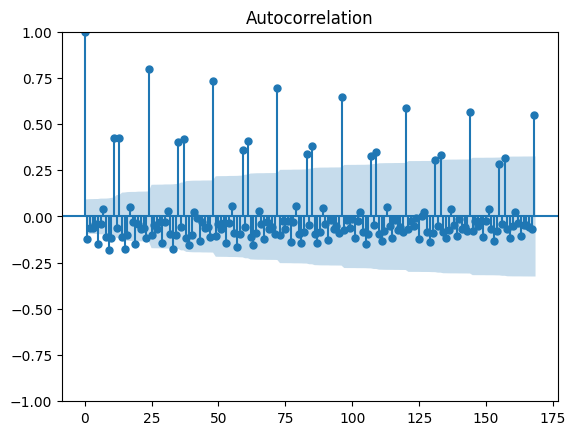

In [8]:
temp = data[data['contributor'] == 'pytorchbot']
lags = min(int((len(temp)/2)-1),168)

acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)

print('The optimal numer of lags is :', np.argmax(acf_values[1:])+1)

# Plot the autocorrelation function
plot_acf(temp['n_activities'].values, lags=lags)
plt.show()

The optimal numer of lags is : 168


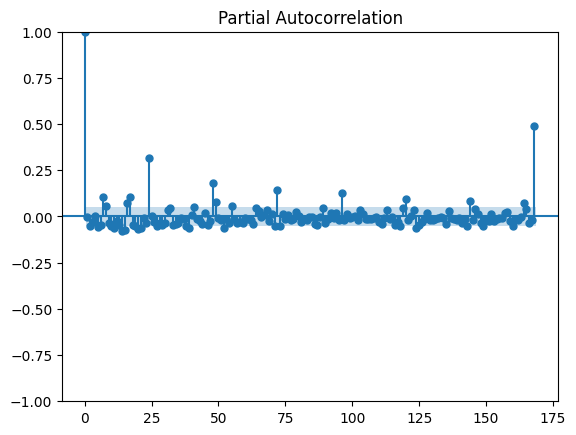

In [9]:
temp = data[data['contributor'] == 'lingohub[bot]']
lags = min(int((len(temp)/2)-1),168)

pacf_values, _ = pacf(temp['n_activities'].values, nlags=lags, alpha=0.05, method='ols')

print('The optimal numer of lags is :', np.argmax(pacf_values[1:])+1)

# Plot the partial autocorrelation function
plot_pacf(temp['n_activities'].values, lags=lags)
plt.show()

Percentage of Predicted Values Greater Than or Equal to Actual Values (PGA), a new evaluation metric that calculates the percentage of predicted values greater than or equal to the actual values. We can define this metric as follows:

$$PGA = \frac{\sum_{i=1}^{n} [y_i \leq \hat{y}_i]}{n} \times 100$$

In [10]:
def pga_score(y_true, y_pred):
    return (y_pred >= y_true).mean()

# 1. Autoregressive model *

Partial autocorrelation is a commonly used tool for identifying the order of an autoregressive model.

In [11]:
def ar_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal number of lags
    lags = min(int((len(train)/2)-1),24*7)
    pacf_values, _ = pacf(train['n_activities'].values, nlags=lags, alpha=0.05, method='ols')
    optimal_lags = np.argmax(pacf_values[1:])+1

    # Fit the model
    model = AutoReg(train['n_activities'], lags=optimal_lags).fit()

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'pga_ci_upper': pga_score(test['n_activities'], predictions['mean_ci_upper']),
        'n_activities': contributor['n_activities'].sum(),
        'optimal_lags': optimal_lags
    })

    return metrics

In [12]:
# Apply the function to each contributor
ar_results = data.groupby(['category', 'contributor']).apply(ar_model).reset_index(drop=True)

0crat
24emebot
5iMON-bot
AmplabJenkins
AppVeyorBot
ArduinoBot
CFPBot
Code-Inside-Bot
CrowdinBot
DrahtBot
Favware-bot
FlexGet-Bot
HT2Bot
Hibernate-CI
HitkoDev
ININ-TransifexAutomation
PJBot
PRB0t
ParadiseSS13-Bot
RiotTranslateBot
SpacemacsBot
SwiftLintBot
UberOpenSourceBot
VaporBot
addonsbot
adobe-bot
adoptopenjdk-github-bot
agones-bot
alluxio-bot
amp-owners-bot[bot]
ampproject-artifacts-bot
analysis-bot
angular-automatic-lock-bot[bot]
ansibot
apmmachine
apollo-cla
aporeto-bot
archzfs-bot
asf-ci
atlassian-cla-bot[bot]
authenticator-bot
aviary2-wf
aws-cdk-automation
aws-sdk-go-automation
babel-bot
backpackbot
backportbot-nextcloud[bot]
ballerina-bot
bedevere-bot
bits-bot
blathers-crl[bot]
blueprint-bot
bluespice-github-bot
boring-cyborg[bot]
bors-servo
bot-gradle
botcerts
bugsnagbot
build-travis-ci
callstack-bot
carsonbot
cb-sdk-robot
cf-gitbot
chainer-ci
cheminfo-bot
cla-bot-2021[bot]
cla-bot[bot]
cla-checker-service[bot]
cloudwanbot
cmsdmwmbot
codeclimate[bot]
codesandbox[bot]
confs-te

In [ ]:
data[data['contributor'] == 'ninjadotorg-bot'].head(60)

In [45]:
ar_results.head()

,contributor,category,r2,mae,rmse,pga,pga_ci_upper,n_activities,optimal_lags
0,0crat,bot,-0.018472,0.050674,0.215147,0.936782,0.988506,118,105
1,24emebot,bot,0.007167,0.240233,0.444137,0.906103,0.967136,285,1
2,5iMON-bot,bot,0.003047,0.032859,0.125780,0.983871,0.983871,38,71
3,AmplabJenkins,bot,0.170956,0.230488,0.758640,0.318182,0.954545,28,63
4,AppVeyorBot,bot,0.003882,0.660736,0.773211,0.631579,0.982456,300,1


In [14]:
ar_results.to_csv('../models-evaluation/ar_model_metrics_ci.csv', index=False)

<Axes: xlabel='optimal_lags', ylabel='count'>

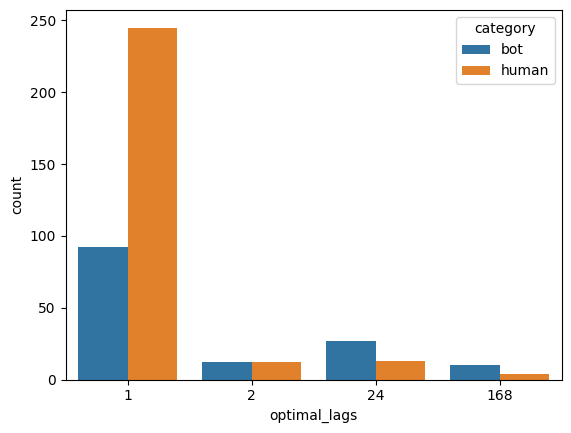

In [15]:
sns.countplot(x='optimal_lags', hue='category', data=ar_results[ar_results['optimal_lags'].isin([1, 2, 24, 168])])

# 2. Moving-average model

In [ ]:
def ma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal number of lags
    lags = min(int((len(train)/2)-1),24*7)
    acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    optimal_lags = np.argmax(acf_values[1:])+1

    # Fit the model
    model = ARIMA(train['n_activities'], order=(0, 0, optimal_lags)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'optimal_lags': optimal_lags
    })

    return metrics

In [ ]:
# Apply the function to each contributor
ma_results = data.groupby(['category', 'contributor']).apply(ma_model).reset_index(drop=True)

In [ ]:
ma_results.sort_values(by='r2', ascending=False).head(40)

In [ ]:
ma_results.to_csv('../models-evaluation/ma_model_metrics.csv', index=False)

In [ ]:
ma_results = pd.read_csv('../models-evaluation/ma_model_metrics.csv')
display(ma_results['optimal_lags'].value_counts().to_frame().head())
sns.countplot(x='optimal_lags', hue='category', data=ma_results[ma_results['optimal_lags'].isin([2, 24])])

# 3. Autoregressive Moving-average model

In [ ]:
def arma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal parameters
    lags = min(int((len(train)/2)-1),24*7)

    pacf_values, _ = pacf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    p = np.argmax(pacf_values[1:])+1

    acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    q = np.argmax(acf_values[1:])+1

    print (p, q)

    # Fit the model
    model = ARIMA(train['n_activities'], order=(1, 0, 1)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'p_order': p,
        'q_order': q
    })

    return print(metrics)

arma_model(data[data['contributor'] == 'lingohub[bot]'])

In [ ]:
def arma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = ARIMA(train['n_activities'], order=(1, 0, 1)).fit(method='innovations_mle')

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
arma_results = data.groupby(['category', 'contributor']).apply(arma_model).reset_index(drop=True)

In [ ]:
arma_results.sort_values(by='r2', ascending=False).head(40)

In [ ]:
arma_results.to_csv('../models-evaluation/arma_model_metrics.csv', index=False)

# 4. Autoregressive integrated Moving-average model

In [ ]:
def arima_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = ARIMA(train['n_activities'], order=(1, 1, 1)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
arima_results = data.groupby(['category', 'contributor']).apply(arima_model).reset_index(drop=True)

In [ ]:
arima_results.sort_values(by='r2', ascending=False).head(40)

In [ ]:
arima_results.to_csv('../models-evaluation/arima_model_metrics.csv', index=False)

# 5. Seasonal Autoregressive integrated Moving-average model *

In [ ]:
import pmdarima as pm

def sarimax_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Use auto_arima to select the optimal seasonal_order parameter
    optimal_model = pm.auto_arima(train['n_activities'], seasonal=True, m=24)

    # Fit the model
    model = SARIMAX(train['n_activities'], order=optimal_model.order, seasonal_order=optimal_model.seasonal_order).fit(disp=False, method='lbfgs')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'order' : optimal_model.order,
        'seasonal_order' : optimal_model.seasonal_order
    })

    return print(metrics)

sarimax_model(data[data['contributor'] == 'lingohub[bot]'])

In [ ]:
def sarima_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = SARIMAX(train['n_activities'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_invertibility=False, enforce_stationarity=False).fit(disp=False, method='lbfgs')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [16]:
def sarima_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = SARIMAX(train['n_activities'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_invertibility=False, enforce_stationarity=False).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'pga_ci_upper': pga_score(test['n_activities'], predictions['mean_ci_upper']),
        'n_activities': contributor['n_activities'].sum(),
    })

    return metrics

In [ ]:
# Apply the function to each contributor
sarima_results = data.groupby(['category', 'contributor']).apply(sarima_model).reset_index(drop=True)

In [50]:
sarima_results.head()

,contributor,category,r2,mae,rmse,pga,pga_ci_upper,n_activities
0,0crat,bot,-0.011617,0.023019,0.214421,0.988506,0.988506,118
1,24emebot,bot,-0.023302,0.140996,0.450901,0.906103,0.967136,285
2,5iMON-bot,bot,-0.016393,0.016129,0.127000,0.155914,0.983871,38
3,AmplabJenkins,bot,-0.047223,0.185262,0.852642,0.863636,0.954545,28
4,AppVeyorBot,bot,-0.155556,0.697968,0.832795,0.631579,0.982456,300


In [55]:
sarima_results['pga'].describe()

count     717.000000
mean       -3.139462
std        74.025037
min     -1980.930929
25%        -0.066911
50%        -0.026305
75%        -0.011379
max         1.000000
Name: r2, dtype: float64

In [19]:
sarima_results.to_csv('../models-evaluation/sarima_model_metrics_ci.csv', index=False)

# 6. Unobserved components model *

In [ ]:
def uc_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = UnobservedComponents(train['n_activities'], level=True, seasonal=24).fit(disp=False, method='lbfgs')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae':  root_mean_squared_mean_absolute_error(test['n_activities'], predictions),
        'mse':error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [20]:
def uc_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = UnobservedComponents(train['n_activities'], level=True, seasonal=24).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'pga_ci_upper': pga_score(test['n_activities'], predictions['mean_ci_upper']),
        'n_activities': contributor['n_activities'].sum(),
    })

    return metrics

In [ ]:
# Apply the function to each contributor
uc_results = data.groupby(['category', 'contributor']).apply(uc_model).reset_index(drop=True)

In [56]:
uc_results.head()

,contributor,category,r2,mae,rmse,pga,pga_ci_upper,n_activities
0,0crat,bot,-1.397541,0.076803,0.330098,0.597701,1.0,118
1,24emebot,bot,-7.204307,0.548972,1.276733,0.338028,1.0,285
2,5iMON-bot,bot,-0.614791,0.036339,0.160078,0.505376,1.0,38
3,AmplabJenkins,bot,-2.024213,0.599630,1.448949,0.545455,1.0,28
4,AppVeyorBot,bot,-10.647437,1.451557,2.643977,0.578947,1.0,300


In [61]:
uc_results['rmse'].describe()

count    7.170000e+02
mean     2.064703e+00
std      3.999523e+00
min      4.662055e-16
25%      3.755171e-01
50%      9.015524e-01
75%      1.907690e+00
max      6.838172e+01
Name: rmse, dtype: float64

In [23]:
uc_results.to_csv('../models-evaluation/uc_model_metrics_ci.csv', index=False)

# 7. Simple exponential smoothing model

In [ ]:
def ses_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = SimpleExpSmoothing(train['n_activities']).fit(smoothing_level=0.8, optimized=False, method='L-BFGS-B', remove_bias=True)

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
ses_results = data.groupby(['category', 'contributor']).apply(ses_model).reset_index(drop=True)

In [ ]:
ses_results.sort_values(by='r2', ascending=False).head(40)

In [ ]:
ses_results.to_csv('../models-evaluation/ses_model_metrics.csv', index=False)

# 8. Holt’s linear (double) exponential smoothing model

In [ ]:
def des_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    model = Holt(train['n_activities'], initialization_method='estimated').fit(method='L-BFGS-B')

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
des_results = data.groupby(['category', 'contributor']).apply(des_model).reset_index(drop=True)

In [ ]:
des_results.sort_values(by='r2', ascending=False).head(40)

In [ ]:
des_results.to_csv('../models-evaluation/des_model_metrics.csv', index=False)

# 9. Holt-Winters (triple) exponential smoothing model *

In [ ]:
def tes_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    try:
        model = ExponentialSmoothing(train['n_activities'], seasonal_periods=24, trend='add', seasonal='add').fit()
    except ValueError:
        model = ExponentialSmoothing(train['n_activities']).fit()
    except:
        print("Something else went wrong")

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': root_mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [24]:
def tes_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Fit the model
    try:
        model = ETSModel(train['n_activities'], error='add', trend='add', seasonal='add', seasonal_periods=24).fit(disp=False)
    except ValueError:
        model = ETSModel(train['n_activities'], error='add', trend='add').fit(disp=False)
    except:
        print("Something else went wrong")

    # Forecast the test set using prediction interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'pga_pi_upper': pga_score(test['n_activities'], predictions['pi_upper']),
        'n_activities': contributor['n_activities'].sum()
    })

    return metrics

In [ ]:
# Apply the function to each contributor
tes_results = data.groupby(['category', 'contributor']).apply(tes_model).reset_index(drop=True)

In [62]:
tes_results.head()

,contributor,category,r2,mae,rmse,pga,pga_pi_upper,n_activities
0,0crat,bot,-0.198591,0.107938,0.233397,0.844828,1.000000,118
1,24emebot,bot,-0.475193,0.472383,0.541382,0.906103,0.967136,285
2,5iMON-bot,bot,-0.011920,0.034534,0.126720,0.473118,0.983871,38
3,AmplabJenkins,bot,-0.096835,0.315743,0.872605,0.954545,0.954545,28
4,AppVeyorBot,bot,-0.406189,0.812774,0.918680,0.754386,0.982456,300


In [63]:
tes_results['rmse'].describe()

count    7.170000e+02
mean     1.081746e+00
std      1.853193e+00
min      4.242156e-16
25%      2.531337e-01
50%      5.963770e-01
75%      1.227585e+00
max      2.505177e+01
Name: rmse, dtype: float64

In [27]:
tes_results.to_csv('../models-evaluation/tes_model_metrics_pi.csv', index=False)

<Axes: xlabel='variable', ylabel='value'>

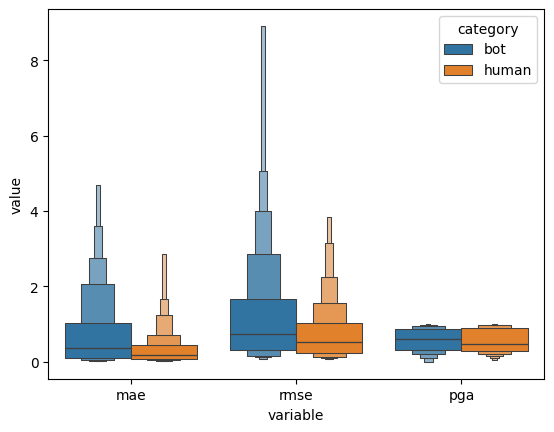

In [69]:
# plot the boxenplot
sns.boxenplot(x='variable', y='value', hue='category', data=pd.melt(tes_results.drop(['r2', 'pga_pi_upper', 'n_activities'], axis=1), id_vars=['contributor', 'category'], var_name='variable', value_name='value'), showfliers=False)

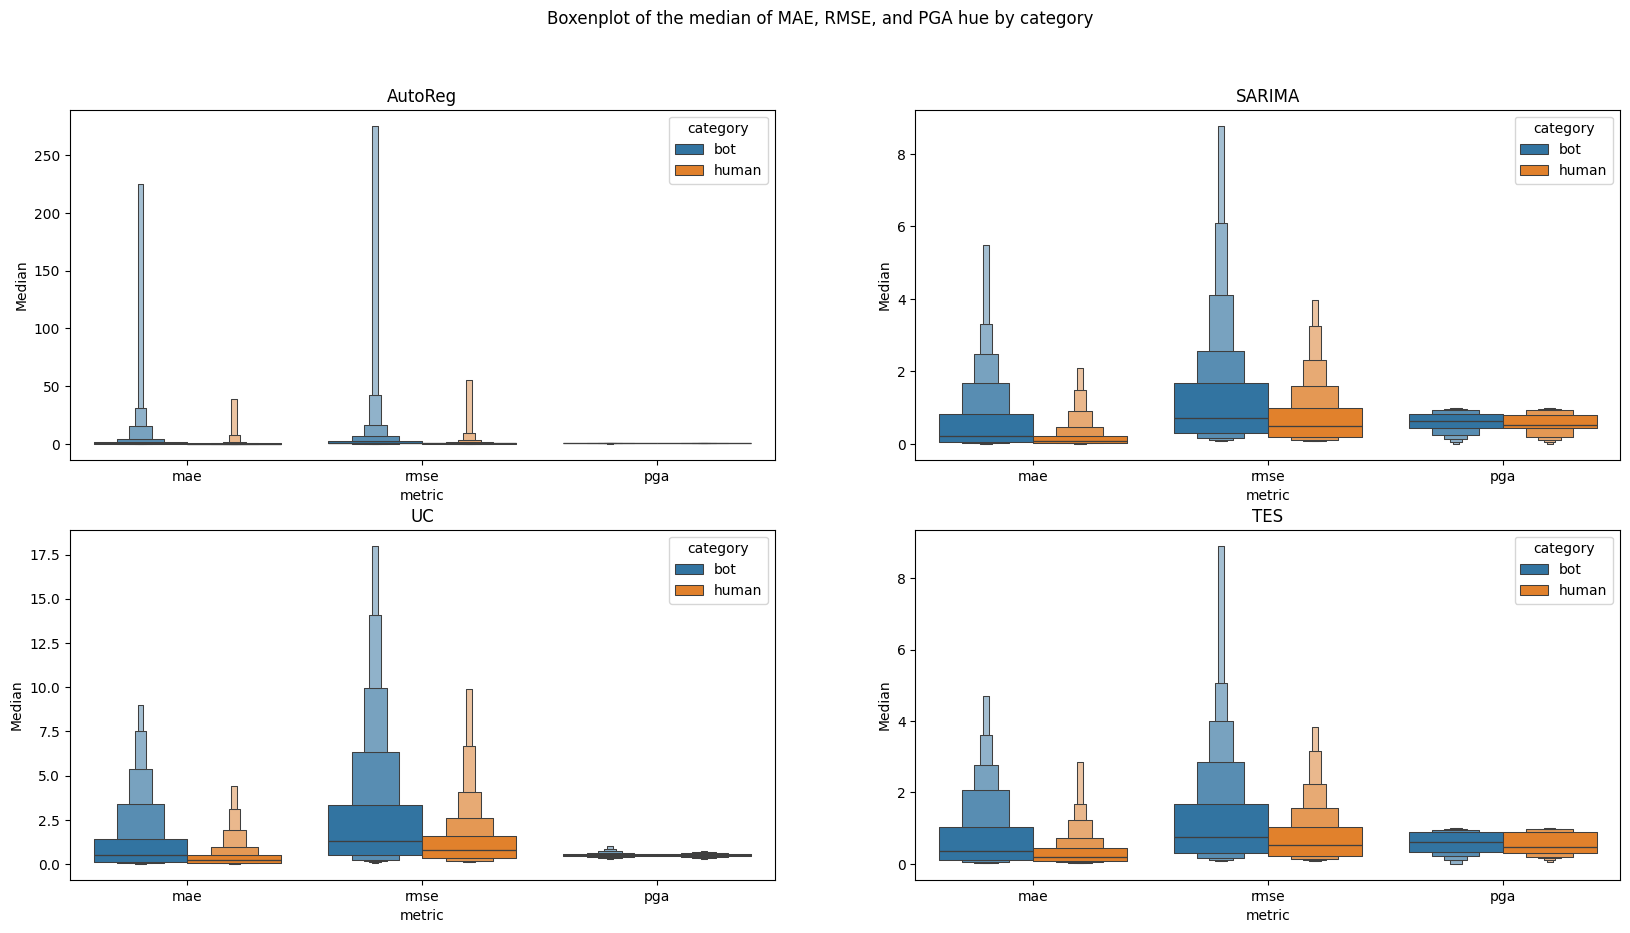

In [77]:
# create dataframes with the given data
data1 = ar_results[['category', 'mae', 'rmse', 'pga']]
data2 = sarima_results[['category', 'mae', 'rmse', 'pga']]
data3 = uc_results[['category', 'mae', 'rmse', 'pga']]
data4 = tes_results[['category', 'mae', 'rmse', 'pga']]

# melt the dataframes
melted_data1 = pd.melt(data1, id_vars=['category'], var_name='metric', value_name='value')
melted_data2 = pd.melt(data2, id_vars=['category'], var_name='metric', value_name='value')
melted_data3 = pd.melt(data3, id_vars=['category'], var_name='metric', value_name='value')
melted_data4 = pd.melt(data4, id_vars=['category'], var_name='metric', value_name='value')

# create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# plot the boxenplots
sns.boxenplot(ax=axs[0, 0], x='metric', y='value', hue='category', data=melted_data1, showfliers=False)
sns.boxenplot(ax=axs[0, 1], x='metric', y='value', hue='category', data=melted_data2, showfliers=False)
sns.boxenplot(ax=axs[1, 0], x='metric', y='value', hue='category', data=melted_data3, showfliers=False)
sns.boxenplot(ax=axs[1, 1], x='metric', y='value', hue='category', data=melted_data4, showfliers=False)

# set the titles
axs[0, 0].set_title('AutoReg')
axs[0, 1].set_title('SARIMA')
axs[1, 0].set_title('UC')
axs[1, 1].set_title('TES')

# set the y-label
axs[0, 0].set_ylabel('Median')
axs[0, 1].set_ylabel('Median')
axs[1, 0].set_ylabel('Median')
axs[1, 1].set_ylabel('Median')

# set the plot title
plt.suptitle('Boxenplot of the median of MAE, RMSE, and PGA hue by category')

# show the plot
plt.show()
